# Multi-temporal Evalscripts

This notebook will show you how to use evalscripts to do multi-temporal analysis with Sentinel Hub.

## Table of Contents
1. [Prerequisites](#prerequisites)
2. [Learning Objectives](#learning-objectives)
3. [Introduction to Multi-temporal Analysis](#introduction)
4. [Mosaicking Options](#mosaicking-options)
5. [Understanding Data Structure](#understanding-data-structure)
6. [Temporal Mean NDVI](#temporal-mean-ndvi)
7. [Exercise: Maximum NDVI](#exercise-maximum-ndvi)
8. [Cloud-free Mosaics](#cloud-free-true-color-mosaics)
9. [Exercise: False Color Composite](#exercise-cloud-free-false-color-composite)
10. [Temporal Change Detection](#temporal-change-detection-ndvi-difference)
11. [Summary and Further Reading](#summary)

## Prerequisites

To carry out this notebook you need the following requisites:

- [Basic Knowledge of Remote Sensing](https://business.esa.int/newcomers-earth-observation-guide)
    - Sensors
    - Spectral Bands
    - Indices
- [Basic Familiarity with Sentinel Hub](https://www.sentinel-hub.com/explore/education/webinars/)
    - Collections
    - Processing API
    - Statistical API
    - Basic understanding of evalscripts (see previous notebook)

## Learning Objectives

By the end of this notebook, you will be able to:

✅ **Understand mosaicking options** - Know the differences between SIMPLE, TILE, and ORBIT mosaicking  
✅ **Work with temporal data structures** - Access samples and scenes arrays in multi-temporal evalscripts  
✅ **Calculate temporal statistics** - Compute mean, maximum, and quartile values across time  
✅ **Create cloud-free composites** - Build mosaics using Scene Classification Layer (SCL) filtering  
✅ **Perform change detection** - Compare NDVI values between different time periods  
✅ **Use preProcessScenes** - Filter scenes by date to reduce processing costs  
✅ **Handle edge cases** - Deal with missing data and invalid pixels in temporal analysis  

## Introduction

Multi-temporal analysis is where Sentinel Hub and evalscripts really shine. Instead of having to download a lot of data to construct a cloudless mosaic or a maximum NDVI composite, all of this can be done in an evalscript, allowing you to only download the end result. 

This approach offers several advantages:
- **Reduced bandwidth** - Only download processed results, not raw data
- **Cloud processing** - Leverage Sentinel Hub's infrastructure for heavy computations
- **Flexible analysis** - Combine multiple temporal aggregation methods in a single script

To illustrate the different concepts of multi-temporal evalscripts, we will look at three use-cases:

- **Cloud-free mosaic** - Creating clear imagery by filtering out cloudy pixels
- **Maximum NDVI composite** - Finding peak vegetation values over time
- **Temporal change detection** - Comparing vegetation between different time periods

In [1]:
import json
from pprint import pprint

import matplotlib.pyplot as plt
from sentinelhub import (
    CRS,
    DataCollection,
    DownloadFailedException,
    Geometry,
    MimeType,
    SentinelHubRequest,
    SHConfig,
)

config = SHConfig()
config.sh_client_id = "<your_client_id>"
config.sh_client_secret = "<your_client_secret>"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

In [2]:
def request_helper(evalscript, start_date="2023-04-01", end_date="2023-04-10"):
    """
    Helper function to make multi-temporal requests with evalscripts.

    Args:
        evalscript (str): JavaScript evalscript code for processing
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format

    Returns:
        list: Response data from Sentinel Hub containing processed imagery

    Note:
        - Uses Sentinel-2 L2A data collection
        - Maximum cloud coverage set to 80%
        - Output size: 1000x1000 pixels
        - Area of interest: Sample region in Brazil
    """
    aoi = Geometry(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [-52.307067, -27.262221],
                    [-52.307067, -27.238987],
                    [-52.280803, -27.238987],
                    [-52.280803, -27.262221],
                    [-52.307067, -27.262221],
                ]
            ],
        },
        CRS.WGS84,
    )
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    "sentinel-2-l2a", service_url=config.sh_base_url
                ),
                time_interval=(start_date, end_date),
                maxcc=0.8,  # max cloud coverage
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=aoi,
        size=[1000, 1000],
        config=config,
    )
    return request.get_data()

## Mosaicking Options

To run multi-temporal evalscripts, we need to set the `mosaicking` key in the setup function. This determines how temporal data is organized and passed to your evalscript.

### Understanding the Three Mosaicking Types

**🔸 SIMPLE (Default)**
- Returns only a **single value per pixel** 
- Selects `mostRecent`, `leastRecent` or `leastCC` (least cloud coverage) tile
- **Cannot be used for multi-temporal analysis**
- Best for: Single-date visualizations

**🔸 TILE** 
- Returns **all tiles** in the time range as separate array elements
- May include multiple values per day (overlapping tiles)
- May include duplicate data from different processing versions
- Best for: Maximum temporal resolution, detailed analysis

**🔸 ORBIT**
- Performs **SIMPLE mosaicking for each day** that has data available
- Returns one value per day (simplified temporal dimension)
- Reduces complexity compared to TILE
- Best for: Daily time series analysis

### Example Setup for Multi-temporal Analysis

```js
function setup() {
    return {
        input: ["B04", "B03", "B02", "SCL", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "TILE"
    };
}
```

In our case we will use `mosaicking: "TILE"`, since we are using Sentinel-2 L2A data which might return multiple unique values per day due to overlapping tiles.

Now let's first use `throw new Error()` to examine how the data is structured in the `evaluatePixel` function.

In [3]:
samples_evalscript = """
//VERSION=3
function setup() {
    return {
        input: ["B04", "B03", "B02", "SCL", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "TILE"
    };
}

function evaluatePixel(samples) {
    throw new Error(JSON.stringify(samples))
    return
}
"""

try:
    request_helper(samples_evalscript, start_date="2023-04-01", end_date="2023-04-10")
except DownloadFailedException as e:
    em = json.loads(e.__cause__.response.text)["error"]["message"]
    # Extract the JSON array from the error message
    error_start = em.find("Error: [")
    if error_start != -1:
        json_start = error_start + 7  # Skip "Error: "
        # Find the end of the JSON array
        bracket_count = 0
        json_end = json_start
        for i in range(json_start, len(em)):
            if em[i] == "[":
                bracket_count += 1
            elif em[i] == "]":
                bracket_count -= 1
                if bracket_count == 0:
                    json_end = i + 1
                    break

        samples_json = em[json_start:json_end]
        samples = json.loads(samples_json)
        pprint(samples)

[{'B02': 0.0407, 'B03': 0.062, 'B04': 0.0767, 'SCL': 4, 'dataMask': 1},
 {'B02': 0.040600000000000004,
  'B03': 0.0626,
  'B04': 0.07730000000000001,
  'SCL': 4,
  'dataMask': 1}]


## Understanding Data Structure

Here we can see the structure of the samples object in `evaluatePixel`. This is fundamentally different from single-temporal evalscripts:

### Single-temporal vs Multi-temporal Structure

**Single-temporal (`mosaicking: "SIMPLE"`):**
```js
// Direct access to band values
samples.B03  // Returns a single number
```

**Multi-temporal (`mosaicking: "TILE"`):**
```js
// Array of temporal samples
samples[0].B03  // First sample's B03 value
samples[1].B03  // Second sample's B03 value
```

### Key Concepts for Multi-temporal Processing

**🔸 dataMask Validation**
- `dataMask: 1` = Valid data available
- `dataMask: 0` = No data (outside tile coverage, gaps)
- **Always check dataMask** before processing pixels

**🔸 Handling Missing Data**
Missing data occurs when:
- Tiles only partially cover your area of interest
- Gaps in satellite coverage
- Data processing issues

**🔸 Temporal Metadata Access**
To get acquisition dates and metadata, use the optional second parameter `scenes`:

```js
function evaluatePixel(samples, scenes) {
    throw new Error(JSON.stringify(scenes.tiles))
    return
}
```

In our specific output, both temporal samples have `dataMask` of 1, meaning both have valid data. However, you may encounter samples with `dataMask` of 0 in other scenarios, so **always validate dataMask** in multi-temporal analysis.

Let's examine the scenes metadata to understand the temporal context:

In [4]:
scenes_evalscript = """
//VERSION=3
function setup() {
    return {
        input: ["B04", "B03", "B02", "SCL", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "TILE"
    };
}

function evaluatePixel(samples, scenes) {
    throw new Error(JSON.stringify(scenes.tiles))
    return
}
"""

try:
    request_helper(scenes_evalscript, start_date="2023-04-01", end_date="2023-04-10")
except DownloadFailedException as e:
    em = json.loads(e.__cause__.response.text)["error"]["message"]
    # Extract the JSON array from the error message
    error_start = em.find("Error: [")
    if error_start != -1:
        json_start = error_start + 7  # Skip "Error: "
        # Find the end of the JSON array
        bracket_count = 0
        json_end = json_start
        for i in range(json_start, len(em)):
            if em[i] == "[":
                bracket_count += 1
            elif em[i] == "]":
                bracket_count -= 1
                if bracket_count == 0:
                    json_end = i + 1
                    break

        scenes_json = em[json_start:json_end]
        scenes = json.loads(scenes_json)
        pprint(scenes)

[{'__idx': 0,
  'cloudCoverage': 0.07,
  'dataPath': 'creo://EODATA/Sentinel-2/MSI/L2A/2023/04/02/S2B_MSIL2A_20230402T133149_N0509_R081_T22JCQ_20230402T155538.SAFE/GRANULE/L2A_T22JCQ_A031710_20230402T133149/IMG_DATA/RRESOLUTION/T22JCQ_20230402T133149_TILEBAND_RESOLUTION',
  'date': '2023-04-02T13:40:09.940Z',
  'productId': 'S2B_MSIL2A_20230402T133149_N0509_R081_T22JCQ_20230402T155538.SAFE',
  'sentinel2ProductId': 'S2B_MSIL2A_20230402T133149_N0509_R081_T22JCQ_20230402T155538.SAFE',
  'shId': 12156348,
  'tileOriginalId': 'S2B_MSIL2A_20230402T133149_N0509_R081_T22JCQ_20230402T155538.SAFE'},
 {'__idx': 1,
  'cloudCoverage': 0.07,
  'dataPath': 'creo://EODATA/Sentinel-2/MSI/L2A_N0500/2023/04/02/S2B_MSIL2A_20230402T133149_N0510_R081_T22JCQ_20240827T131314.SAFE/GRANULE/L2A_T22JCQ_A031710_20230402T133149/IMG_DATA/RRESOLUTION/T22JCQ_20230402T133149_TILEBAND_RESOLUTION',
  'date': '2023-04-02T13:40:08.904Z',
  'productId': 'S2B_MSIL2A_20230402T133149_N0510_R081_T22JCQ_20240827T131314.SAFE',
 

We can see that it returns metadata for each temporal sample. The scenes array corresponds directly to the samples array - each index contains metadata for the same temporal observation.

### Key Temporal Metadata for Sentinel-2 L2A

Key metadata available for Sentinel-2 L2A:
- `date`: Acquisition timestamp (`2023-04-02T13:40:09.940Z`)
- `cloudCoverage`: 0.07 (7% cloud coverage)
- `productId`: Sentinel-2 product identifier

Now let's do the first analysis in the evalscript.

## Temporal Mean NDVI

To do this we loop through all of our samples in the array. Per sample we then check if it is a valid sample. In our case valid data means that the data is not cloudy (using SCL - Scene Classification Layer) and the `dataMask` is 1. If it isn't we can immediately continue to the next sample.

If the sample is valid we can calculate the NDVI and sum it up. To finally calculate the mean we also need to keep track of how many samples were valid.

With multi temporal scripts it is also really important to think of **edge cases**. In this script we have to think of the case where all returned samples might be invalid. We need to handle this specific case so that the output is well defined.

```js
var NODATA = NaN;
function evaluatePixel(samples) {
   var sum = 0;
   var valid = 0;
   
   // Loop through all samples
   for(let i=0; i<samples.length; i++){
       let sample = samples[i];
       // Check if the sample is valid using SCL (Scene Classification Layer)
       if(!sample.dataMask || [3, 8, 9, 10, 11].includes(sample.SCL)){
           // continue to the next sample if not valid (clouds, shadows, etc.)
           continue;
       }
       // calculate NDVI if sample is valid
       const ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
       // add the ndvi to the sum
       sum += ndvi;
       // increment the number of valid samples
       valid++
   }

   // Check if there is any valid samples
   if(valid==0){
       return [NODATA]
   }
   
   const mean = sum / valid
   return [mean]
}
```


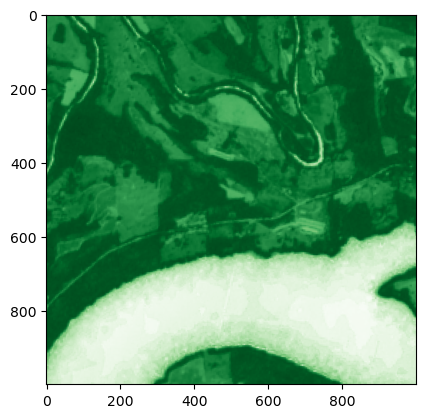

In [5]:
mean_ndvi_evalscript = """
//VERSION=3
var NODATA = NaN;

function setup() {
   return {
       input: ["B04", "B08", "SCL", "dataMask"],
       output: {
           bands: 1,
           sampleType: "FLOAT32",
           nodataValue: NODATA
       },
       mosaicking: "TILE"
   };
}

function evaluatePixel(samples) {
   var sum = 0;
   var valid = 0;

   // Loop through all samples
   for(let i=0; i<samples.length; i++){
       let sample = samples[i];
       // Check if the sample is valid using SCL (Scene Classification Layer)
       if(!sample.dataMask || [3, 8, 9, 10, 11].includes(sample.SCL)){
           // continue to the next sample if not valid (clouds, shadows, etc.)
           continue;
       }
       // calculate NDVI if sample is valid
       const ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
       // add the ndvi to the sum
       sum += ndvi;
       // increment the number of valid samples
       valid++
   }

   // Check if there is any valid samples
   if(valid==0){
       return [NODATA]
   }

   const mean = sum / valid
   return [mean]
}
"""

mean_ndvi_data = request_helper(
    mean_ndvi_evalscript, start_date="2023-04-01", end_date="2023-04-15"
)
plt.imshow(mean_ndvi_data[0], cmap="Greens");

And just like that we have calculated the mean NDVI for half a month. You can also try calculating the mean NDVI for an entire month or even a quarter or full year. Be aware though, that the Processing API has a timeout which will limit very large requests. If you do run into this timeout you might want to look into the [Asynchronous Processing API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/AsyncProcess.html).

## Exercise: Maximum NDVI

Now it's your turn to modify this script. The task now is to calculate the maximum NDVI over the time range. 

The basic idea stays the same:

1. Loop over all samples which are returned
2. Check if the sample is valid
3. If the sample is valid calculate NDVI
4. Check if the NDVI value is larger than the current max and if so overwrite it
5. Handle edge cases

Hint: You can initialize the variable which holds the current max with `Number.NEGATIVE_INFINITY`. This way every new NDVI value will be larger than the initilized value.

<details><summary>See solution</summary>

```js
//VERSION=3
var NODATA = NaN;

function setup() {
   return {
       input: ["B04", "B08", "SCL", "dataMask"],
       output: {
           bands: 1,
           sampleType: "FLOAT32",
           nodataValue: NODATA
       },
       mosaicking: "TILE"
   };
}

function evaluatePixel(samples) {
   var max = Number.NEGATIVE_INFINITY;
   
   // Loop through all samples
   for(let i=0; i<samples.length; i++){
       let sample = samples[i];
       // Check if the sample is valid using SCL
       if(!sample.dataMask || [3, 8, 9, 10, 11].includes(sample.SCL)){
           // continue to the next sample if not valid
           continue;
       }
       // calculate NDVI if sample is valid
       const ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
       // check if ndvi is larger than current max
       if(ndvi > max){
           max = ndvi;
       }
   }

   if(max == Number.NEGATIVE_INFINITY){
       return [NODATA]
   }
   
   return [max]
}
```
</details>


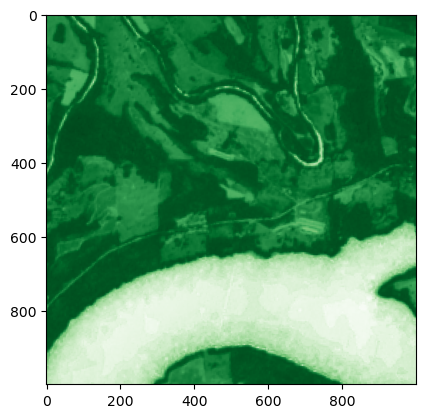

In [6]:
max_ndvi_evalscript = """

"""
max_ndvi_data = request_helper(
    max_ndvi_evalscript, start_date="2023-04-01", end_date="2023-04-15"
)
plt.imshow(max_ndvi_data[0], cmap="Greens");

## Cloud-free True Color Mosaics

Next we want to create cloud-free mosaics - composite images where cloudy pixels are replaced with clear observations from other dates.

Next we want to have a look at how to construct cloud free mosaics. The same general concept as before applies. However now instead of doing statistics on just NDVI, we have to apply it to all three bands required to construct a true color image.

We also want to use the first quartile value of each band. We do this to reduce the possible impact of any clouds that the cloud mask did not catch. This is because taking the first quartile value over the time range will return a slightly darker value than the mean or median. This further reduces the likelihood that we pick a cloudy pixel for the composite.

To do this, we need one array per band. To make this simpler and reusable we use a global variable in which we define the bands we want to return cloudless pixels for.

**🔸 Multi-band Processing**
We need to apply temporal statistics to all RGB bands simultaneously:
```js
var bands = ["B04", "B03", "B02"];  // Red, Green, Blue
```

This is then used in evaluate pixel to initialize an object where we store an array for each band with the valid sample values.

```js
var validSamples = {};
for(let i=0; i<bands.length; i++){
    validSamples[bands[i]] = [];
}
```

So now we have an object `validSamples` which looks like this:

```js
{
    "B04": [],
    "B03": [],
    "B02": []
}
```

In those empty arrays we will push the valid samples in the loop:

```js
if(!sample.dataMask || [3, 8, 9, 10, 11].includes(sample.SCL)){
    // continue to the next sample if not valid
    continue;
}
// Push valid samples to respective arrays
for(let i=0; i<bands.length; i++){
    validSamples[bands[i]].push(sample[bands[i]]);
}
```

and finally we handle the edge case of no valid values. If we do have valid values we get the first quartile of those values:

```js
// Take the first quartile value in each of the bands
var compositePixel = new Array(bands.length);
for(let i=0; i<bands.length; i++){
    const validBandValues = validSamples[bands[i]]
    const firstQuartile = getFirstQuartileValue(validBandValues)
    compositePixel[i] = firstQuartile;
}
return compositePixel;
```

Let's see what this request returns.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.846].


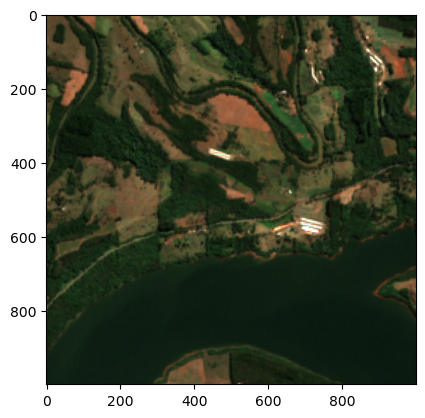

In [7]:
cloud_free_evalscript = """
//VERSION=3
var NODATA = 0;
var bands = ["B04", "B03", "B02"];

function setup() {
   return {
       input: bands.concat(["SCL", "dataMask"]),
       output: {
           bands: bands.length,
           sampleType: "UINT16",
           nodataValue: NODATA
       },
       mosaicking: "TILE"
   };
}

function getFirstQuartileValue(values) {
   values.sort((a,b) => a-b);
   return getFirstQuartile(values);
}

function getFirstQuartile(sortedValues) {
   var index = Math.floor(sortedValues.length / 4);
   return sortedValues[index];
}

function evaluatePixel(samples) {
   var validSamples = {};
   for(let i=0; i<bands.length; i++){
       validSamples[bands[i]] = [];
   }
   
   // Loop through all samples
   for(let i=0; i<samples.length; i++){
       let sample = samples[i];
       // Use less restrictive cloud masking - only exclude high probability clouds
       if(!sample.dataMask || [8, 9, 10].includes(sample.SCL)){
           continue;
       }
       // Push valid samples to respective arrays
       for(let j=0; j<bands.length; j++){
           validSamples[bands[j]].push(sample[bands[j]] * 10000); // Scale up reflectance values
       }
   }

   // Check if there is any valid samples
   if(validSamples[bands[0]].length==0){
       var outNodata = [];
       for(let i=0; i<bands.length; i++){
           outNodata.push(NODATA);
       }
       return outNodata
   }

   // Take the first quartile value in each of the bands
   var compositePixel = new Array(bands.length);
   for(let i=0; i<bands.length; i++){
       const validBandValues = validSamples[bands[i]]
       const firstQuartile = getFirstQuartileValue(validBandValues)
       compositePixel[i] = firstQuartile;
   }
   return compositePixel;
}
"""

cloud_free_data = request_helper(
    cloud_free_evalscript, start_date="2023-04-01", end_date="2023-04-15"
)
plt.imshow(cloud_free_data[0] / 2000);

This looks like a nice cloud free composite.

### Exercise: Cloud Free False Color Composite 

This exercise should be quite easy. Try to modify the above script to return a false color composite.  
Hint: a False Color Composite for Sentinel-2 is usually `["B08", "B04", "B03"]` (NIR, Red, Green)

<details><summary>See solution</summary>

```js
//VERSION=3
var NODATA = 0;
var bands = ["B08", "B04", "B03"];

function setup() {
   return {
       input: bands.concat(["SCL", "dataMask"]),
       output: {
           bands: bands.length,
           sampleType: "UINT16",
           nodataValue: NODATA
       },
       mosaicking: "TILE"
   };
}

function getFirstQuartileValue(values) {
   values.sort((a,b) => a-b);
   return getFirstQuartile(values);
}

function getFirstQuartile(sortedValues) {
   var index = Math.floor(sortedValues.length / 4);
   return sortedValues[index];
}

function evaluatePixel(samples) {
   var validSamples = {};
   for(let i=0; i<bands.length; i++){
       validSamples[bands[i]] = [];
   }
   
   // Loop through all samples
   for(let i=0; i<samples.length; i++){
       let sample = samples[i];
       // Use less restrictive cloud masking
       if(!sample.dataMask || [8, 9, 10].includes(sample.SCL)){
           continue;
       }
       // Push valid samples to respective arrays
       for(let j=0; j<bands.length; j++){
           validSamples[bands[j]].push(sample[bands[j]] * 10000);
       }
   }

   // Check if there is any valid samples
   if(validSamples[bands[0]].length==0){
       var outNodata = [];
       for(let i=0; i<bands.length; i++){
           outNodata.push(NODATA);
       }
       return outNodata
   }

   // Take the first quartile value in each of the bands
   var compositePixel = new Array(bands.length);
   for(let i=0; i<bands.length; i++){
       const validBandValues = validSamples[bands[i]]
       const firstQuartile = getFirstQuartileValue(validBandValues)
       compositePixel[i] = firstQuartile;
   }
   return compositePixel;
}
```
</details>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.0495].


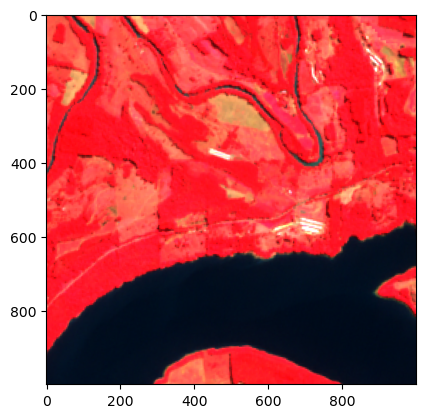

In [8]:
fc_composite_evalscript = """

"""
fc_composite_data = request_helper(
    fc_composite_evalscript, start_date="2023-04-01", end_date="2023-04-15"
)
plt.imshow(fc_composite_data[0] / 2000);

Finally let's look at the case where we are only interested in very specific dates in our time of interest. A common case for that is change detection. For example the difference of NDVI between two dates.

## Temporal Change Detection: NDVI difference

In this analysis we want to look at the difference between two hand picked days: one in the beginning of May 2022 and the other end of April 2023. To do this we have to set the time range to an entire year (2022-05-01 to 2023-05-01). However we are only interested in two days in all of this data. To reduce the amount of data transmitted to the `evaluatePixel` function (and thus also the associated PU cost) we can use the function `preProcessScenes`.

This function runs before `evaluatePixel` and after `setup`. It has one parameter usually called `collections`. This parameter has a very similiar structure to `scenes` in `evaluatePixel` but let's have a closer look:

In [9]:
collections_evalscript = """
//VERSION=3
function setup() {
   return {
       input: ["B04", "dataMask"],
       output: {
           bands: 1,
           sampleType: "FLOAT32",
       },
       mosaicking: "TILE"
   };
}

function preProcessScenes(collections){
   throw new Error(JSON.stringify(collections.scenes.tiles))
}

function evaluatePixel(samples) {
   return [0]
}
"""

try:
    request_helper(
        collections_evalscript, start_date="2022-05-01", end_date="2023-05-01"
    )
except DownloadFailedException as e:
    em = json.loads(e.__cause__.response.text)["error"]["message"]
    # Extract the JSON array from the error message
    error_start = em.find("Error: [")
    if error_start != -1:
        json_start = error_start + 7  # Skip "Error: "
        # Find the end of the JSON array
        bracket_count = 0
        json_end = json_start
        for i in range(json_start, len(em)):
            if em[i] == "[":
                bracket_count += 1
            elif em[i] == "]":
                bracket_count -= 1
                if bracket_count == 0:
                    json_end = i + 1
                    break

        collections_json = em[json_start:json_end]
        collections = json.loads(collections_json)
        pprint(collections)

[{'__idx': 0,
  'cloudCoverage': 41.25,
  'dataPath': 'creo://EODATA/Sentinel-2/MSI/L2A/2023/04/27/S2A_MSIL2A_20230427T133151_N0509_R081_T22JCQ_20230427T183900.SAFE/GRANULE/L2A_T22JCQ_A040976_20230427T133145/IMG_DATA/RRESOLUTION/T22JCQ_20230427T133151_TILEBAND_RESOLUTION',
  'date': '2023-04-27T13:40:06.655Z',
  'productId': 'S2A_MSIL2A_20230427T133151_N0509_R081_T22JCQ_20230427T183900.SAFE',
  'sentinel2ProductId': 'S2A_MSIL2A_20230427T133151_N0509_R081_T22JCQ_20230427T183900.SAFE',
  'shId': 14606154,
  'tileOriginalId': 'S2A_MSIL2A_20230427T133151_N0509_R081_T22JCQ_20230427T183900.SAFE'},
 {'__idx': 1,
  'cloudCoverage': 41.24,
  'dataPath': 'creo://EODATA/Sentinel-2/MSI/L2A_N0500/2023/04/27/S2A_MSIL2A_20230427T133151_N0510_R081_T22JCQ_20240902T215228.SAFE/GRANULE/L2A_T22JCQ_A040976_20230427T133145/IMG_DATA/RRESOLUTION/T22JCQ_20230427T133151_TILEBAND_RESOLUTION',
  'date': '2023-04-27T13:40:05.655Z',
  'productId': 'S2A_MSIL2A_20230427T133151_N0510_R081_T22JCQ_20240902T215228.SAFE',

We can see that collections holds similiar data to `scenes`. However you access that data with `collections.scenes.tiles` when `mosaicking: "TILES"` and with `collections.scenes.orbits` when `mosaicking: "ORBIT"`.

You can think of `preProcessScenes` as doing a catalog request just to see what kind of tiles are available in your area and time of interest. You can then modify the list to exclude certain elements. In the end the modified collections object is returned in the `preProcessScenes` function and only those tiles which are included in that collections object will get requested and passed to the `evaluatePixel` function.

So in our case we want to request exactly two dates. This can be done with this function:

```js
function preProcessScenes(collections) {
    var allowedDates = ["2022-06-11", "2023-04-02"];
    collections.scenes.orbits = collections.scenes.orbits.filter(function (orbit) {
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    });
    return collections;
}
```

Here we will actually switch to `mosaicking: ORBIT` because we only want a single value per day. Let's see what the output of our filtering is:

In [10]:
collections_evalscript = """
//VERSION=3
function setup() {
    return {
        input: ["B04", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function preProcessScenes (collections) {
    var allowedDates = ["2022-06-11", "2023-04-02"];  // Use dates that have data
    collections.scenes.orbits = collections.scenes.orbits.filter(function (orbit) {
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    })
    throw new Error(JSON.stringify(collections.scenes.orbits))
    return collections
}

function evaluatePixel(samples) {
    return [0]
}
"""

try:
    request_helper(
        collections_evalscript, start_date="2022-04-01", end_date="2023-05-01"
    )
except DownloadFailedException as e:
    em = json.loads(e.__cause__.response.text)["error"]["message"]
    # Extract the JSON array from the error message
    error_start = em.find("Error: [")
    if error_start != -1:
        json_start = error_start + 7  # Skip "Error: "
        bracket_count = 0
        json_end = json_start
        for i in range(json_start, len(em)):
            if em[i] == "[":
                bracket_count += 1
            elif em[i] == "]":
                bracket_count -= 1
                if bracket_count == 0:
                    json_end = i + 1
                    break

        collections_json = em[json_start:json_end]
        collections = json.loads(collections_json)
        pprint(collections)

[{'__idx': 3,
  'dateFrom': '2023-04-02T00:00:00Z',
  'dateTo': '2023-04-02T23:59:59Z',
  'tiles': []},
 {'__idx': 40,
  'dateFrom': '2022-06-11T00:00:00Z',
  'dateTo': '2022-06-11T23:59:59Z',
  'tiles': []}]


Looking good! We reduced the list of all orbits down to only one, which is the date we selected. For a proper change detection analysis, you would need two dates with available data. Now we can get to the analysis in the `evaluatePixel` function.

In it, we just calculate the NDVI for both dates and subtract the NDVI value of the old image from the NDVI value of the new image and return this value. Again we also check for missing values.

```js
function evaluatePixel(samples) {
   let old = samples[1];
   let recent = samples[0];
   if( !old.dataMask || [3, 8, 9, 10, 11].includes(old.SCL) || 
       !recent.dataMask || [3, 8, 9, 10, 11].includes(recent.SCL) ){
       return [NODATA]
   }
   
   // Calculate NDVI for both dates
   let oldNDVI = (old.B08 - old.B04) / (old.B08 + old.B04);
   let recentNDVI = (recent.B08 - recent.B04) / (recent.B08 + recent.B04);
   
   // Return the temporal difference
   let difference = recentNDVI - oldNDVI;
   return [difference]
}
```

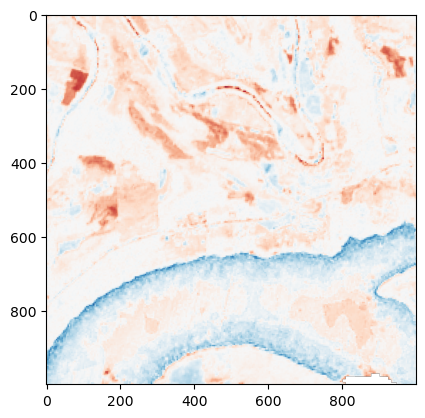

In [11]:
ndvi_diff_evalscript = """
//VERSION=3
var NODATA = NaN;

function setup() {
   return {
       input: ["B08", "B04", "SCL", "dataMask"],
       output: {
           bands: 1,
           sampleType: "FLOAT32",
           nodataValue: NODATA
       },
       mosaicking: "ORBIT"
   };
}

function preProcessScenes (collections) {
   var allowedDates = ["2022-06-11", "2023-04-02"];
   collections.scenes.orbits = collections.scenes.orbits.filter(function (orbit) {
       var orbitDateFrom = orbit.dateFrom.split("T")[0];
       return allowedDates.includes(orbitDateFrom);
   })
   return collections
}

function evaluatePixel(samples) {
   let old = samples[1];
   let recent = samples[0];
   if( !old.dataMask || [8, 9, 10].includes(old.SCL) || !recent.dataMask || [8, 9, 10].includes(recent.SCL) ){
       return [NODATA]
   }
   let oldNDVI = (old.B08 - old.B04) / (old.B08 + old.B04);
   let recentNDVI = (recent.B08 - recent.B04) / (recent.B08 + recent.B04);
   let difference = recentNDVI - oldNDVI;
   return [difference]
}
"""

ndvi_diff_data = request_helper(
    ndvi_diff_evalscript, start_date="2022-04-01", end_date="2023-05-01"
)
plt.imshow(ndvi_diff_data[0], cmap="RdBu", vmin=-1.0, vmax=1.0);

Here we can see pixels with lower NDVI in 2023 in red and with higher NDVI in blue. We also have a strip of missing data which we nicely handled with our edge case check.

The `preProcessScenes` function is quite powerful and can subset the returned tiles in a wide variety of ways. For more examples see the [documentation](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript/Functions.html#preprocessscenes-function-optional).

## Summary

In this notebook we've learned about the mosaicking options `SIMPLE`, `TILE` and `ORBIT` and what their differences are. We've learned how to access the `samples` object in `evaluatePixel` when doing multi-temporal analysis. In terms of analysis we've seen how to do cloud-free mosaics, maximum and mean NDVI composites and temporal NDVI differences.

For more multi-temporal evalscripts check out these examples on the custom script page:

- [Snow Cover Change Detection](https://custom-scripts.sentinel-hub.com/sentinel-2/snow_cover_change/)
- [Forest Cut Detection](https://custom-scripts.sentinel-hub.com/sentinel-2/forest_cut_temporal_detection/)
- [Vegetation Condition Index](https://custom-scripts.sentinel-hub.com/sentinel-2/vegetation_condition_index/)